# Import libraries

In [10]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from data_loader import JesterV1
from network.R3D import R3D

import warnings
warnings.filterwarnings('ignore', message = 'The default value of the antialias parameter of all the resizing transforms*')

In [11]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
    # Get the name of the GPU
    print('GPU Device Name:', torch.cuda.get_device_name(0)) # Change the device index if you have multiple GPUs
else:
    device = torch.device('cpu')
    print('GPU not available, using CPU instead')
    
print('Selected device:', device)

GPU not available, using CPU instead
Selected device: cpu


# Load dataset

Set training parameters

In [12]:
batch_size = 1
num_epochs = 10
learning_rate = 0.001
num_workers = 4 # Number of threads for data loading
validation_interval = 1 # Perform validation every n epochs

Create an instance of the dataset

In [13]:
# Define dataset
data_dir = '..\datasets\JESTER-V1'

# Define transformations
transform_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((96, 96)),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((96, 96)),
])

transform = transform_2

# Create an instance of the dataset
train_dataset = JesterV1(
    data_dir = data_dir,
    num_frames = 30,
    transform = transform,
    mode = 'train',
) # Train dataset
val_dataset = JesterV1(
    data_dir = data_dir,
    num_frames = 30,
    transform = transform,
    mode = 'val',
) # Validation dataset

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers) # Train data loader
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers) # Validation data loader

Double-check dataset

In [14]:
# Length of DataLoader
print("Number of batches:", len(train_loader))
# Inspect a batch
for frames, labels in train_loader:
    print("Shape of frames tensor:", frames.shape)
    print("Shape of labels tensor:", labels.shape)
    break
# Length of Dataset
print("Number of samples:", train_dataset.__len__())

Number of batches: 118562
Shape of frames tensor: torch.Size([1, 3, 30, 96, 96])
Shape of labels tensor: torch.Size([1])
Number of samples: 118562


tensor([6])


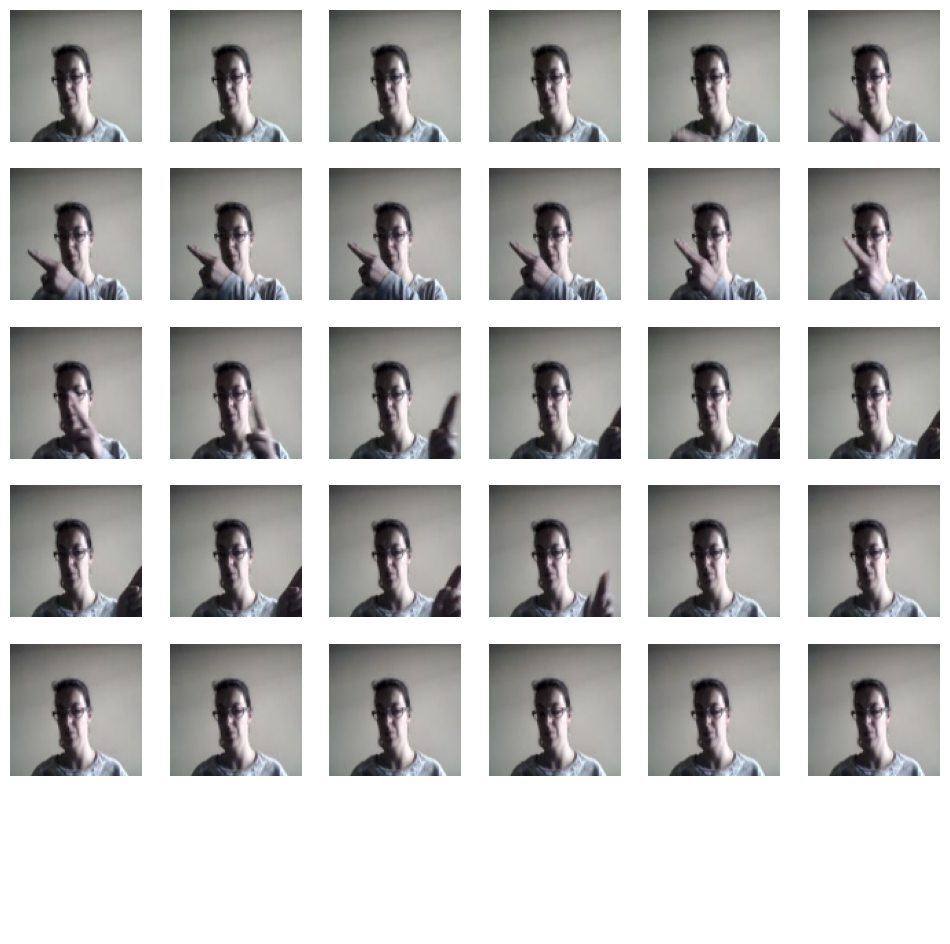

In [15]:
# Visualize a batch of frames
for frames, labels in train_loader:
    print(labels) # Print the labels
    # Get the first sample of the batch
    batch = frames.permute(0, 2, 1, 3, 4)
    images = batch[0]
    
    # Plot the images
    h, w = 0, 0
    fig, ax = plt.subplots(6, 6, figsize = (12, 12))
    # Transpose the images
    images.permute(1, 0, 2, 3)
    # Plot the images
    for image in images:
        ax[h, w].imshow(image.permute(1, 2, 0)) # Transpose the image to (H, W, C)
        ax[h, w].axis('off')
        w += 1
        if w == 6:
            h += 1
            w = 0
    remain = 36 - images.shape[0]
    # Remove the remaining axes
    for i in range(remain):
        ax[h, w].axis('off')
        w += 1
        if w == 6:
            h += 1
            w = 0
    # Display the plot
    plt.show()
    
    break

# Define models

### R3D

In [16]:
model = R3D(
    18,
    n_input_channels = 3,
    conv1_t_size = 7,
    conv1_t_stride = 1,
    no_max_pool = False,
    widen_factor = 1.0,
    n_classes = 28
).to(device)

In [17]:
print(model)

ResNet(
  (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

### R2Plus1D